An example of using COAsT to analysis observational profile data alongside gridded NEMO data. 

### Load modules

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [14]:
import coast
import glob  # For getting file paths
import gsw
import matplotlib.pyplot as plt
import datetime
import numpy as np
import xarray as xr
import coast._utils.general_utils as general_utils
import scipy as sp

# ====================== UNIV PARAMS ===========================
path_examples = "../../example_files/"
path_config = "../../config/"

### load and preprocess profile and model data

In [3]:
fn_wod_var = path_examples + "WOD_example_ragged_standard_level.nc"
fn_wod_config = path_config + "example_wod_profiles.json"

wod_profile_1d = coast.Profile(config=fn_wod_config)
wod_profile_1d.read_wod(fn_wod_var)

../../config/example_wod_profiles.json


Reshape into 2D.
Choose which observed variables you want.

In [4]:
var_user_want = ["salinity", "temperature", "nitrate", "oxygen", "dic", "phosphate", "alkalinity"]
wod_profile = coast.Profile.reshape_2d(wod_profile_1d, var_user_want)

Depth OK reshape successful
salinity
observed variable exist
OK reshape successful
temperature
observed variable exist
OK reshape successful
nitrate
variable not in observations
oxygen
observed variable exist
OK reshape successful
dic
observed variable exist
OK reshape successful
phosphate
observed variable exist
OK reshape successful
alkalinity
variable not in observations


Keep subset.

In [5]:
wod_profile_sub = wod_profile.subset_indices_lonlat_box(lonbounds=[90, 120], latbounds=[-5, 5])


In [6]:
#wod_profile_sub.dataset # uncomment to print data object summary

SEAsia read BGC.
Note in this simple test nemo data are only for 3 months from 1990 so the comparisons are not going to be correct but just as a demo.

In [7]:
fn_seasia_domain = path_examples + "coast_example_domain_SEAsia.nc"
fn_seasia_config_bgc = path_config + "example_nemo_bgc.json"
fn_seasia_var = path_examples + "coast_example_SEAsia_BGC_1990.nc"

seasia_bgc = coast.Gridded(
    fn_data=fn_seasia_var, fn_domain=fn_seasia_domain, config=fn_seasia_config_bgc, multiple=True
)

Domain file does not have mask so this is just a trick.

In [8]:
seasia_bgc.dataset["landmask"] = seasia_bgc.dataset.bottom_level == 0
seasia_bgc.dataset = seasia_bgc.dataset.rename({"depth_0": "depth"})
model_profiles = wod_profile_sub.obs_operator(seasia_bgc)
#model_profiles.dataset # uncomment to print data object summary

Remove any points that are far from model.

In [9]:
too_far = 5
keep_indices = model_profiles.dataset.interp_dist <= too_far
model_profiles = model_profiles.isel(id_dim=keep_indices)
wod_profile = wod_profile_sub.isel(id_dim=keep_indices)

In [10]:
#wod_profile.dataset # uncomment to print data object summary

### Plot profiles
Transform observed DIC from mmol/l to mmol C/ m^3 that the model has.

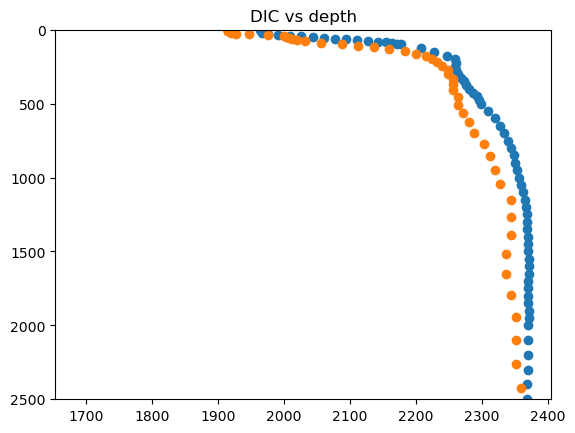

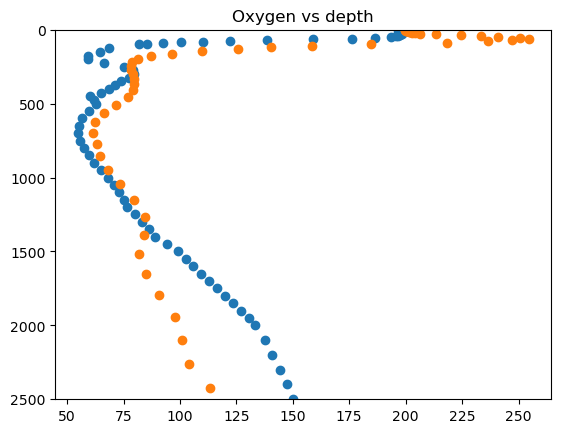

In [11]:
fig = plt.figure()
plt.plot(1000 * wod_profile.dataset.dic[8, :], wod_profile.dataset.depth[8, :], linestyle="", marker="o")
plt.plot(model_profiles.dataset.dic[8, :], model_profiles.dataset.depth[:, 8], linestyle="", marker="o")
plt.ylim([2500, 0])
plt.title("DIC vs depth")
plt.show()

fig = plt.figure()
plt.plot(wod_profile.dataset.oxygen[8, :], wod_profile.dataset.depth[8, :], linestyle="", marker="o")
plt.plot(model_profiles.dataset.oxygen[8, :], model_profiles.dataset.depth[:, 8], linestyle="", marker="o")
plt.ylim([2500, 0])
plt.title("Oxygen vs depth")
plt.show()

### Perform profile analysis to evaluate differences
Interpolate seasia to profile depths, using `ProfileAnalysis` class.

In [12]:
reference_depths = wod_profile.dataset.depth[20, :].values
model_profiles.dataset = model_profiles.dataset[["dic"]] / 1000

pa = coast.ProfileAnalysis()
model_interpolated = pa.interpolate_vertical(model_profiles, wod_profile)

Calculate differences.

In [13]:
differences = pa.difference(model_interpolated, wod_profile)
#differences.dataset.load() # uncomment to print data object summary